In [194]:
import pandas as pd
import os
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
import json

In [195]:
path_log = "./log"

In [196]:
cfg = json.load(open("config.json", "r"))

In [197]:
dt = cfg["run"]["dt"]
center_x = cfg["geometry"]["width"]["size"] / 2
center_y = cfg["geometry"]["depth"]["size"] / 2
center_z = cfg["geometry"]["height"]["size"] / 2
dt, center_x, center_y, center_z

(1000, 100.0, 100.0, 100.0)

In [198]:
threads = sorted(os.listdir(pathLog))
threads

['th0']

In [199]:
particle_types = []
for particle_type_item in cfg["particle-types"]:
    particle_type = particle_type_item["type"]
    particle_types.append(particle_type)
particle_types

['O2', 'rO2*']

In [200]:
diffusion_stat = OrderedDict()
for particle_type in particle_types:
    diffusion_stat[particle_type] = OrderedDict()
    for th in threads:
        diffusion_stat[particle_type][th] = []

In [201]:
for th in threads:
    path_thread = f"{path_log}/{th}"
    path_coords = f"{path_thread}/coords"
    ts_files = sorted(os.listdir(path_coords))
    
    for fn_timestep_log in ts_files:
        path_timestep_log = f"{path_coords}/{fn_timestep_log}"
        
        df = pd.read_csv(path_timestep_log, sep=",", index_col="particle-id")
        for particle_type in particle_types:
            dfpt = df[df["particle-type"] == particle_type]
            var_x = ((dfpt["x"] - center_x)**2).mean()
            var_y = ((dfpt["y"] - center_y)**2).mean()
            var_z = ((dfpt["z"] - center_z)**2).mean()
            var = var_x + var_y + var_z
            diffusion_stat[particle_type][th].append(var)

In [202]:
n = 2
for particle_type in particle_types:
    t = n * dt
    var = diffusion_stat[particle_type]["th0"][n]
    # 6Dt = var 
    # D_h2o  = 0.002 * mm2/s
    # D_O2o  = 0.002 * mm2/s
    # D_h2o2 = 0.0012 * mm2/s
    D = var / (6*t)  # A^2/ps
    D_mm2s = D * (10**-14) * (10**12)
    print(particle_type, round(D, 5), "A2 / ps")
    print(particle_type, round(D_mm2s, 9), "mm2 / s")

O2 0.18896 A2 / ps
O2 0.001889589 mm2 / s
rO2* 0.01302 A2 / ps
rO2* 0.00013016 mm2 / s


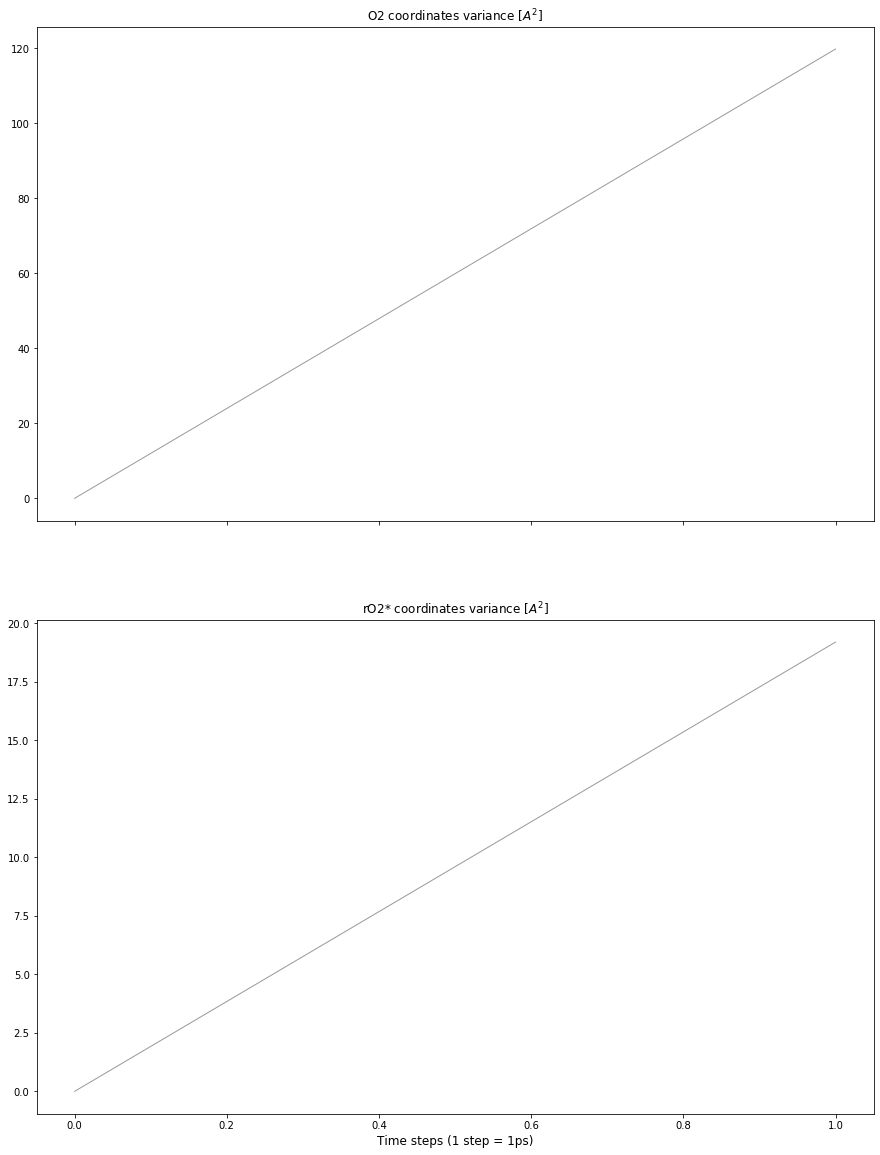

In [175]:
fig, ax = plt.subplots(len(particle_types), 1, sharex=True, figsize=(15,20))
fig.subplots_adjust(hspace=0.2)
for p in range(len(particle_types)):
    particle_type = particle_types[p]

    for th in threads:
        ax[p].plot(diffusion_stat[particle_type][th][0:n], color='black', alpha=0.4, linewidth=1)
    ax[p].set_title(particle_type + " coordinates variance [$A^2$]", fontsize='large')

    #ax[p].legend()
plt.xlabel("Time steps (1 step = 1ps)", fontsize='large')
plt.savefig("variance.png", dpi=300)